## CNN based learning anomaly patterns

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from collections import defaultdict
from multiprocessing import cpu_count

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 1
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [5]:
import pathlib
from sklearn.preprocessing import minmax_scale
from scipy.stats import zscore

class TSDatasetAnomalyPatterns(Dataset):
    def __init__(self, path: pathlib.Path, downsampling: int = 1, scaling: str = "minmax"):
        super(TSDatasetAnomalyPatterns, self).__init__()
        self.df = pd.read_json(str(path), orient='records', lines=True)

        def preprocess(x):
            x = np.array(x)
            x = np.mean(x.reshape(-1, downsampling), axis=1) if downsampling > 1 else x
            # standarlize max/min  {1, 0}
            match scaling:
                case "minmax":
                    return minmax_scale(x, feature_range=(0, 1))
                case "zscore":
                    return zscore(x)
                case _:
                    assert False, f"Unknown scaling: {scaling}"
                
        self.time_series = torch.tensor([
            self.df.loc[:, "time_series"].apply(lambda x: preprocess(x))
        ], dtype=torch.float32)  # use float64 to avoid error

        # def _join_category(x):
        #     if x["anomaly_pattern"] in ["Sudden increase", "Sudden decrease"]:
        #         return x["anomaly_pattern"]
        #     return "/".join(x.dropna().astype(str).values)

        self.joined_categories = self.df.loc[:, ["anomaly_pattern", "anomaly_position"]].apply(
            lambda x: "/".join(x.dropna().astype(str).values), axis=1
        ).to_numpy()

        # string labels to int labels
        self.label_to_category = {i: v for i, v in enumerate(np.unique(self.joined_categories))}
        category_to_label = {v: k for k, v in self.label_to_category.items()}
        self.labels = torch.tensor([
            category_to_label[c] for c in self.joined_categories
        ], dtype=torch.int64)

    def __getitem__(self, idx):
        label = self.labels[idx]
        category = self.label_to_category[label.item()]
        return self.time_series[:, idx], label, category

    def __len__(self):
        return len(self.df)

    def number_of_class(self) -> int:
        return len(self.label_to_category.keys())
    
    def categories(self) -> set[str]:
        return set(self.label_to_category.values())

In [6]:
import torch.utils.data
from sklearn.model_selection import train_test_split


dataset = TSDatasetAnomalyPatterns(pathlib.Path("../samples/tsdr_anomaly_patterns/labeled_tsdr_anomaly_patterns_20221210-145911.jsonl"), downsampling=1, scaling="minmax")
print(dataset.number_of_class(), len(dataset.categories()))
display(dataset.df.groupby(["anomaly_pattern", "anomaly_position"]).size().sort_values(ascending=False))

train_indices, test_indices = train_test_split(list(range(len(dataset.labels))), test_size=0.2, stratify=dataset.labels.tolist())
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

print(f"train size {len(train_dataset)}, test size {len(test_dataset)}")

23 23


anomaly_pattern             anomaly_position     
White noise                 no_anomaly               284
Other normal                no_anomaly               133
Level shift down            anomaly_during_fault     130
Transient level shift down  anomaly_during_fault     116
Single spike                anomaly_during_fault     113
Level shift up              anomaly_during_fault      96
Single dip                  anomaly_during_fault      83
Transient level shift up    anomaly_during_fault      76
Single spike                anomaly_outside_fault     67
Level shift down            anomaly_outside_fault     58
Steady decrease             anomaly_during_fault      49
Multiple spikes             anomaly_outside_fault     46
Sudden increase             anomaly_during_fault      45
Steady increase             anomaly_during_fault      39
Fluctuations                anomaly_during_fault      39
Level shift up              anomaly_outside_fault     38
Transient level shift up    anomaly_ou

train size 1218, test size 305


In [7]:
# ref. https://github.com/pytorch/examples/blob/f82f5626b6432b8d0b08d58cc91f3bdbb355a772/mnist/main.py

class CNN1d(nn.Module):
    def __init__(self, num_classes: int):
        super(CNN1d, self).__init__()

        self.conv1 = nn.Conv1d(1, 64, kernel_size=4, stride=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=4, stride=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=4, stride=1)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(4608, 64)  # the number of datapoints in a metric = 60/15 * 45 (45min * 15sec interval)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, num_classes)  # The number of class is 13 (chaos types) * 2 (anomaly position) + 2 (normal and unknown)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool1d(x, kernel_size=4, stride=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool1d(x, kernel_size=4, stride=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool1d(x, kernel_size=4, stride=2)
        x = torch.flatten(x, 1)  # Is this necessary?
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [8]:
from torchinfo import summary

model = CNN1d(num_classes=dataset.number_of_class()).to(device)
learning_rate = 0.001
epochs = 10
batch_size = 4
test_batch_size = 4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

summary(model, input_size=(batch_size, 1, 180))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1d                                    [4, 23]                   --
├─Conv1d: 1-1                            [4, 64, 177]              320
├─Conv1d: 1-2                            [4, 128, 84]              32,896
├─Conv1d: 1-3                            [4, 256, 38]              131,328
├─Dropout: 1-4                           [4, 4608]                 --
├─Linear: 1-5                            [4, 64]                   294,976
├─BatchNorm1d: 1-6                       [4, 64]                   128
├─Dropout: 1-7                           [4, 64]                   --
├─Linear: 1-8                            [4, 23]                   1,495
Total params: 461,143
Trainable params: 461,143
Non-trainable params: 0
Total mult-adds (M): 32.43
Input size (MB): 0.00
Forward/backward pass size (MB): 1.02
Params size (MB): 1.84
Estimated Total Size (MB): 2.87

In [16]:
from dataclasses import dataclass, field

@dataclass
class ScoreHistory:
    train_loss_values: list[float] = field(default_factory=list)
    train_acc_values: list[float] = field(default_factory=list)
    test_loss_values: list[float] = field(default_factory=list)
    test_acc_values: list[float] = field(default_factory=list)
    epochs: int = 0

    def latest_loss_pair(self) -> tuple[float, float]:
        return self.train_loss_values[-1], self.test_loss_values[-1]

    def latest_acc_pair(self) -> tuple[float, float]:
        return self.train_acc_values[-1], self.test_acc_values[-1]

    def append_train(self, loss: float, acc: float):
        self.train_loss_values.append(loss)
        self.train_acc_values.append(acc)
    
    def append_test(self, loss: float, acc: float):
        self.test_loss_values.append(loss)
        self.test_acc_values.append(acc)
    
    def loss(self, sum_loss, batch_size: int, data_size: int) -> float:
        return sum_loss * batch_size / data_size
    
    def plots(self):
        fig = plt.figure(tight_layout=True, figsize=(7, 3))
        axs = fig.subplots(nrows=1, ncols=2)
        ax_loss, ax_acc = axs[0], axs[1]
        for title, ax, train_values, test_values in zip(("loss", "accuracy"), (ax_loss, ax_acc), (self.train_loss_values, self.train_acc_values), (self.test_loss_values, self.test_acc_values)):
            ax.set_title(title)
            if len(train_values) > 0:
                ax.plot(range(self.epochs), train_values)
            if len(test_values) > 0:
                ax.plot(range(self.epochs), test_values, c='#00ff00')
            ax.set_xlim(0, self.epochs)
            ax.set_ylim(0, max(train_values + test_values) + 0.1)
            ax.set_xlabel("epoch")
            ax.set_ylabel(title)
            ax.legend([f"train {title}", f"test {title}"])
        return fig


from sklearn.metrics import confusion_matrix
import seaborn as sns


@dataclass
class PredictionResult:
    categories: set[str]
    target_labels: list[int] = field(default_factory=list)
    pred_labels: list[int] = field(default_factory=list)

    def append(self, _pred_labels: list[int], _target_labels: list[int]):
        self.target_labels += _target_labels
        self.pred_labels += _pred_labels

    def confusion_matrix(self, normalized=True):
        cm = confusion_matrix(self.target_labels, self.pred_labels)
        if normalized:
            return cm / cm.sum(axis=1, keepdims=True)
        return cm
    
    def aggregated_confusion_matrix(self, normalized=True):
        class_to_aggregated_class: dict[int, int] = {}
        for i, c in enumerate(self.categories):
            if c in ["Other normal/no_anomaly", "White noise/no_anomaly"]:
                class_to_aggregated_class[i] = 0  # Normal class
            else:
                class_to_aggregated_class[i] = 1  # Anomaly class
        agg_target_labels = list(map(lambda x: class_to_aggregated_class[x], self.target_labels))
        agg_pred_labels = list(map(lambda x: class_to_aggregated_class[x], self.pred_labels))
        cm = confusion_matrix(agg_target_labels, agg_pred_labels)
        if normalized:
            return cm / cm.sum(axis=1, keepdims=True)
        return cm
    
    def plot(self):
        fig = plt.figure(tight_layout=True, figsize=(18, 18))
        ax = fig.subplots(nrows=1, ncols=1)
        ax.tick_params(pad=2)
        ax.tick_params(bottom="off", top="off")
        ax.tick_params(left="off")
        ax.tick_params(bottom=False, left=False, right=False, top=False)
        ax = sns.heatmap(
            data=self.confusion_matrix(), cmap='Blues', annot=True, annot_kws={"fontsize": 11}, fmt='.2f',
            linewidths=.2, linecolor="lightgray", square=True, cbar=False,
            cbar_kws={"drawedges": True}, ax=ax,
        )
        ax.set_xticks(np.arange(len(self.categories)))
        ax.set_yticks(np.arange(len(self.categories)))
        ax.set_xticklabels(self.categories, fontsize=7, rotation=45)
        ax.set_yticklabels(self.categories, fontsize=7, rotation=45, va='top')
        ax.set_xlabel("Predict Label", fontsize=12)
        ax.set_ylabel("Target Label", fontsize=12)

    def plot_as_anomaly_or_not(self):
        fig = plt.figure(tight_layout=True, figsize=(5, 2))
        ax = fig.subplots(nrows=1, ncols=1)
        ax.tick_params(pad=2)
        ax.tick_params(bottom="off", top="off")
        ax.tick_params(left="off")
        ax.tick_params(bottom=False, left=False, right=False, top=False)
        ax = sns.heatmap(
            data=self.aggregated_confusion_matrix(), cmap='Blues', annot=True, annot_kws={"fontsize": 9}, fmt='.2f',
            linewidths=.2, linecolor="lightgray", square=True, cbar=False,
            cbar_kws={"drawedges": True}, ax=ax,
        )
        _agg_categories = ["Normal", "Anomaly"]
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(_agg_categories, fontsize=5, rotation=45, ha='center')
        ax.set_yticklabels(_agg_categories, fontsize=5, rotation=45, va='center')
        ax.set_xlabel("Predict Label", fontsize=9)
        ax.set_ylabel("Target Label", fontsize=9)


def train(model, device, train_loader, optimizer, loss_fn):
    model.train()
    for data, target, category in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()


def test_train_data(model, device, train_loader, loss_fn, score_history: ScoreHistory):
    model.eval()
    loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for data, target, category in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    
    loss = score_history.loss(loss, len(train_loader), len(train_loader.dataset)) 
    score_history.append_train(
        loss=loss,
        acc=correct / total,
    )

    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    

def test(model, device, test_loader, loss_fn, score_history: ScoreHistory, pred_res: PredictionResult):
    model.eval()
    loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for data, target, category in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
            
            pred_res.append(pred.view_as(target).tolist(), target.tolist())

    loss = score_history.loss(loss, len(test_loader), len(test_loader.dataset)) 
    score_history.append_test(
        loss=loss, 
        acc=correct / total,
    )

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Split dataset as train and test set.

  0%|          | 0/32 [00:00<?, ?it/s]

Train set: Average loss: 8.5310, Accuracy: 633/1218 (52%)
Test set: Average loss: 2.4076, Accuracy: 151/305 (50%)
Train set: Average loss: 7.0587, Accuracy: 696/1218 (57%)
Test set: Average loss: 2.0302, Accuracy: 158/305 (52%)
Train set: Average loss: 5.0433, Accuracy: 799/1218 (66%)
Test set: Average loss: 1.5043, Accuracy: 193/305 (63%)
Train set: Average loss: 4.3133, Accuracy: 857/1218 (70%)
Test set: Average loss: 1.3256, Accuracy: 209/305 (69%)
Train set: Average loss: 3.7730, Accuracy: 896/1218 (74%)
Test set: Average loss: 1.1233, Accuracy: 215/305 (70%)
Train set: Average loss: 3.3166, Accuracy: 977/1218 (80%)
Test set: Average loss: 1.0095, Accuracy: 232/305 (76%)
Train set: Average loss: 2.3332, Accuracy: 1059/1218 (87%)
Test set: Average loss: 0.8073, Accuracy: 246/305 (81%)
Train set: Average loss: 2.3029, Accuracy: 1037/1218 (85%)
Test set: Average loss: 0.9607, Accuracy: 236/305 (77%)
Train set: Average loss: 1.9073, Accuracy: 1052/1218 (86%)
Test set: Average loss: 0.7

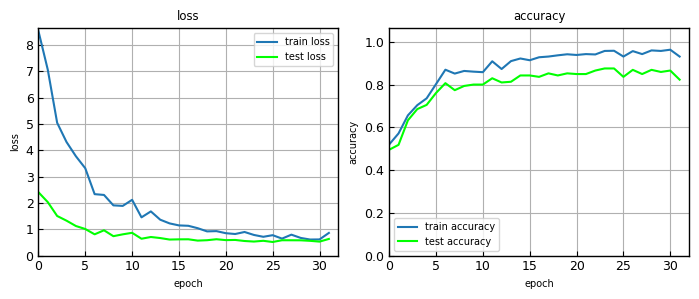

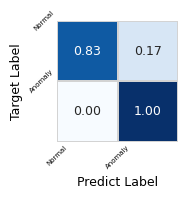

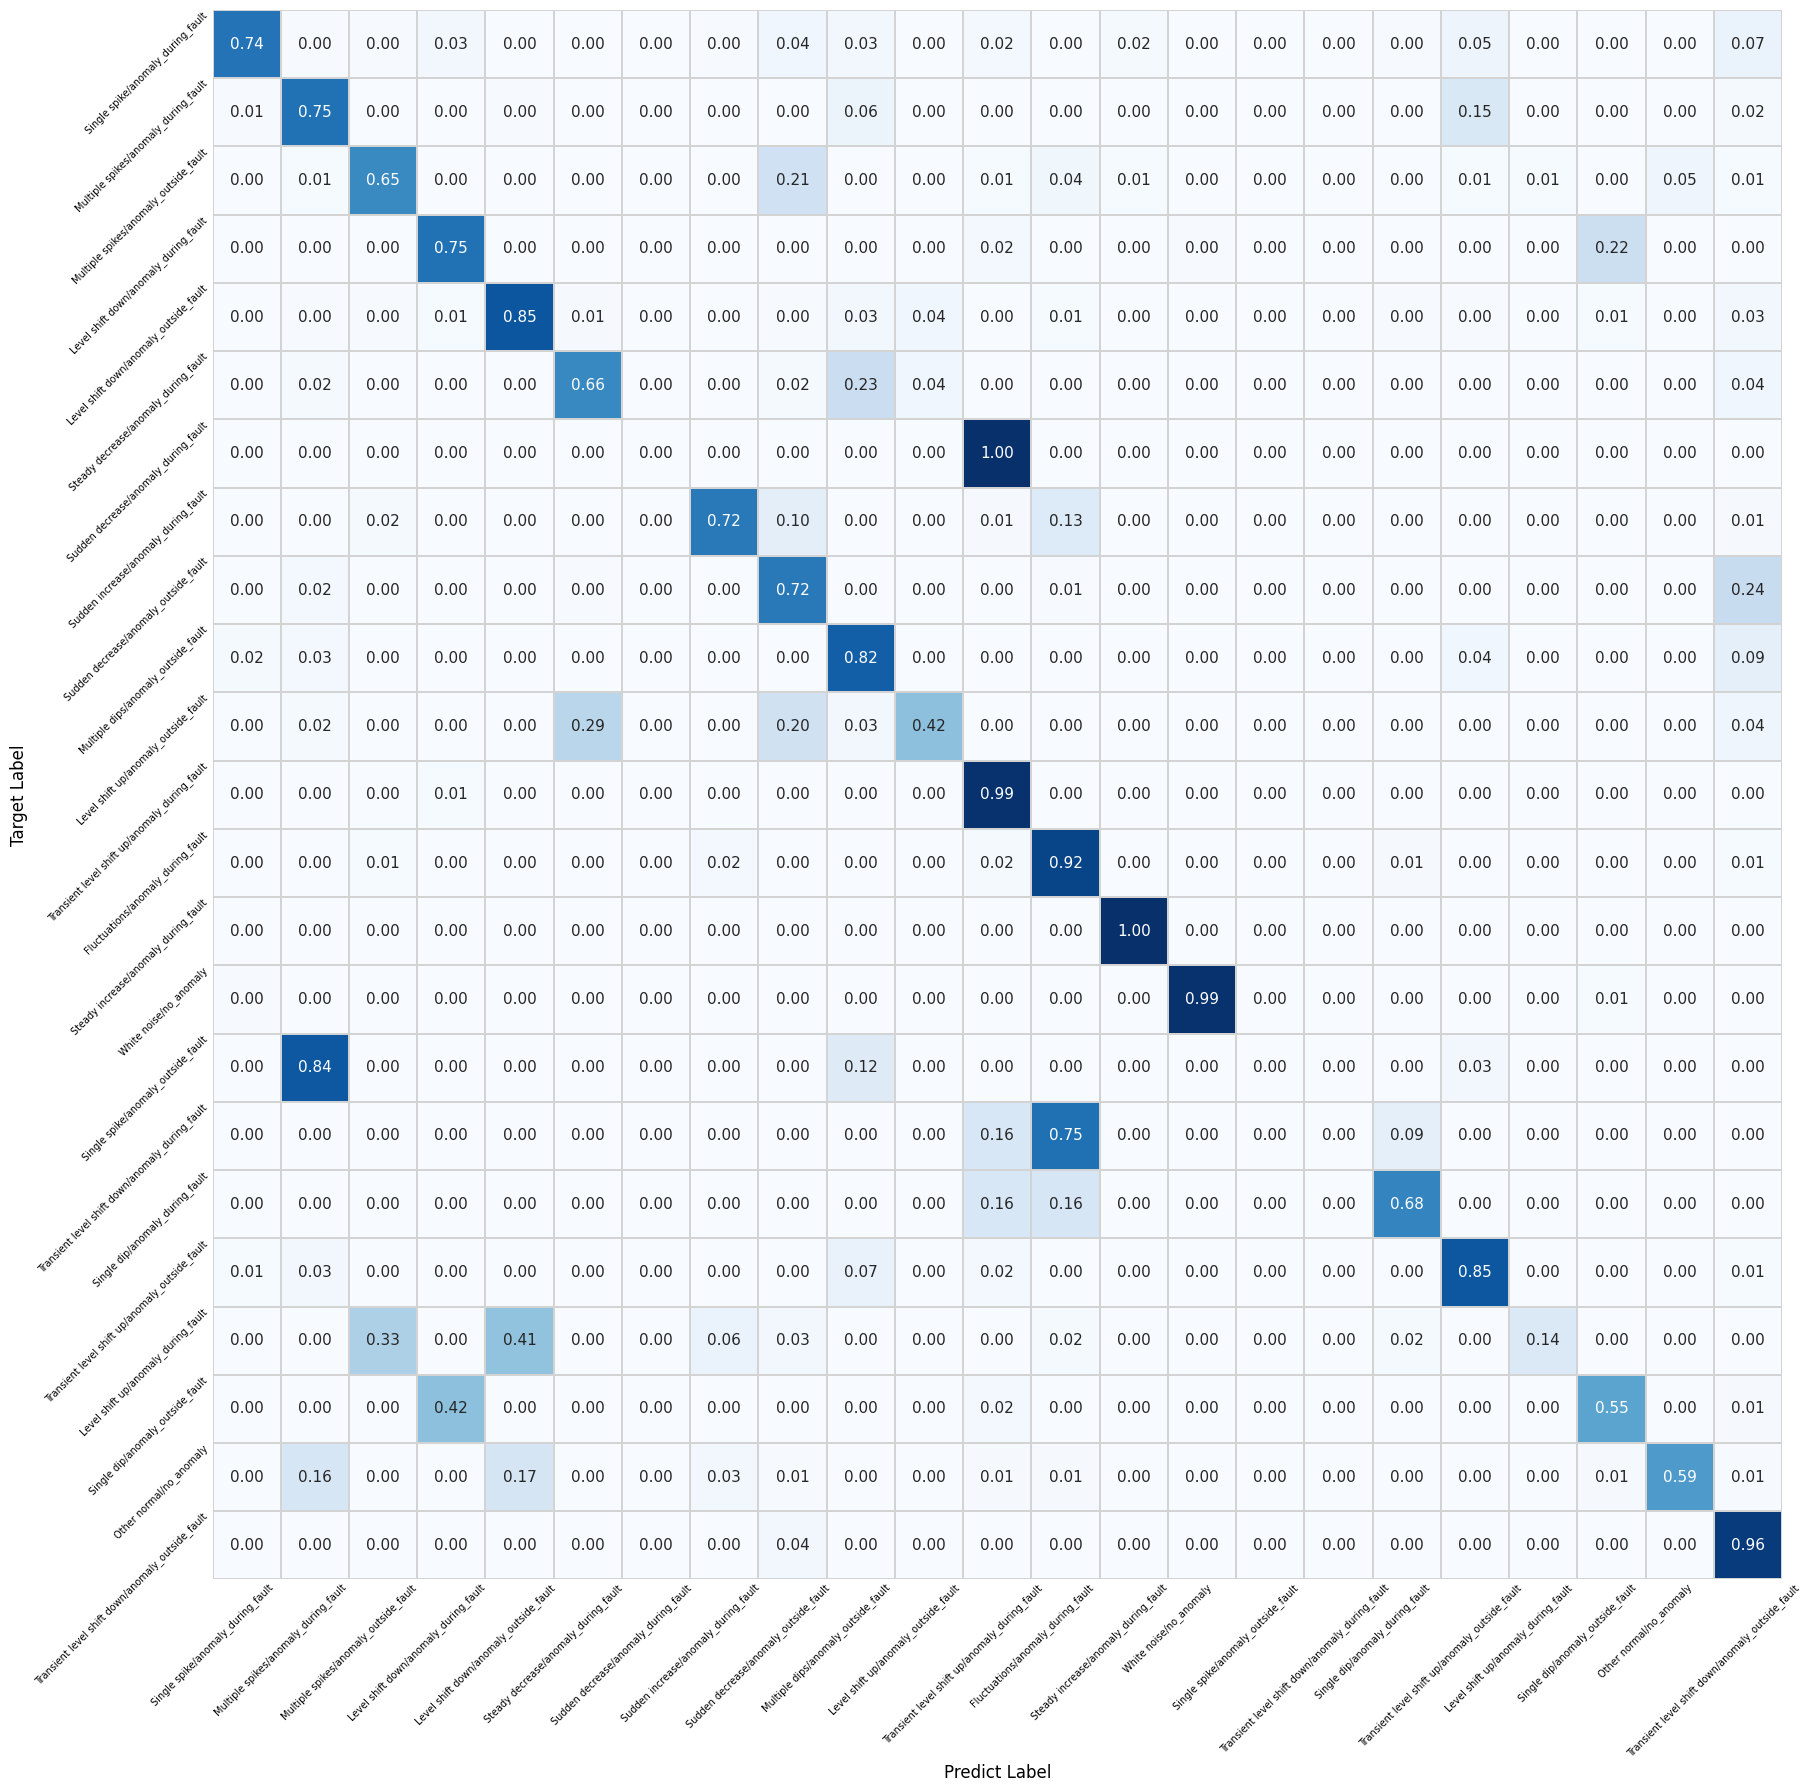

In [18]:
from collections import OrderedDict

from tqdm.notebook import tqdm


model = CNN1d(num_classes=dataset.number_of_class()).to(device)
learning_rate = 0.001
epochs = 32
batch_size = 16
test_batch_size = 16
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, pin_memory=True)

score_hist = ScoreHistory(epochs=epochs)
pred_res = PredictionResult(categories=dataset.categories())

with tqdm(range(1, epochs + 1)) as pbar_epochs:
    for epoch in pbar_epochs:
        pbar_epochs.set_description(f"[Epoch {epoch}]")

        train(model, device, train_dataloader, optimizer, loss_fn)
        test_train_data(model, device, train_dataloader, loss_fn, score_hist)
        test(model, device, test_dataloader, loss_fn, score_hist, pred_res)
        train_loss, test_loss = score_hist.latest_loss_pair()
        train_acc, test_acc = score_hist.latest_acc_pair()
        pbar_epochs.set_postfix(OrderedDict(
            train_loss=train_loss, test_loss=test_loss,
            train_acc=train_acc, test_acc=test_acc,
        ))

score_hist.plots()
plt.show()
pred_res.plot_as_anomaly_or_not()
plt.show()
pred_res.plot()
plt.show()

### Save model

In [11]:
torch.save(model, "models/current_best_cnn1d.pt")